# Imports

In [ ]:
import torch
import torch.nn as nn
from random import shuffle
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix,roc_auc_score
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

from google.colab import drive
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import torch.nn.functional as F
from datasets import Dataset
import evaluate
from typing import List, Tuple
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

In [ ]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


# Function to load fmnist dataset

In [ ]:
fmnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def load_fmnist_torch(root="./data", transform=None, download=True):

    if transform == None:
        transform = T.ToTensor()

    train_set = FashionMNIST(root=root,  transform=transform, download=download, train=True)
    test_set = FashionMNIST(root=root,  transform=transform, download=download, train=False)

    # Each item in this dictionary is a torch Dataset object
    # To feed the data into a model, you may have to use a DataLoader
    return {"train": train_set, "test": test_set}

#  SmallCNN Model

In [ ]:
class SmallCNN(nn.Module):

    def __init__(self):
        super(SmallCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA available! Training on GPU.", flush=True)
else:
    device = torch.device('cpu')
    print("CUDA NOT available... Training on CPU.", flush=True)

CUDA available! Training on GPU.


# Problem 1

In [ ]:
# Load FMNIST dataset
fmnist = load_fmnist_torch()
fmnist_train = fmnist['train']
fmnist_test = fmnist['test']


100%|██████████| 26.4M/26.4M [00:08<00:00, 3.17MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:03<00:00, 1.30MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
print(len(fmnist["test"]))
print(len(fmnist["train"]))

10000
60000


In [ ]:
# TODO: Load and train mdoel

train_loader = DataLoader(fmnist["train"], batch_size = 64, shuffle=True)
print(len(fmnist["train"]))
test_loader = DataLoader(fmnist["test"], batch_size = 64, shuffle=True)
print(len(fmnist["test"]))


images, labels = next(iter(train_loader))

# Model Instantiated:
model = SmallCNN()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

#print(len(fmnist_train))

# Train the model
drive.mount('/content/drive')
# model.train()
# num_epochs = 10
# for epoch in range(num_epochs):
#   for images, labels in train_loader:
#     images,labels = images,labels
#     #print(images.shape)
#     #print(type(labels))

#     optimizer.zero_grad()
#     outputs = model(images)
#     loss = criterion(outputs,labels)
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# torch.save(model.state_dict(), '/content/drive/My Drive/model.pth')
# print("Save Completed")

60000
Mounted at /content/drive


In [ ]:
# TO DO: Test model
test_loader = DataLoader(fmnist["test"], batch_size = 64, shuffle=True)
print(len(fmnist["test"]))

images, labels = next(iter(test_loader))

#Set the Model to Evaluation Mode
model.load_state_dict(torch.load('/content/drive/My Drive/model.pth'))
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         #print(predicted.shape)
#         #predicted = predicted.unsqueeze(1)
#         #print("images",images.shape)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(correct)
# print(total)
# accuracy = (correct / total) * 100
# print(f"Test Accuracy: {accuracy:.2f}%")


10000


<ipython-input-9-f028f47c26be>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/model.pth'))


<All keys matched successfully>

In [ ]:
random.seed(42)
torch.manual_seed(42)

fmnist_member_indices = random.sample(range(len(fmnist_train)), 500)
fmnist_nonmember_indices = random.sample(range(len(fmnist_test)), 500)

fmnist_member_set = Subset(fmnist_train, fmnist_member_indices)
fmnist_nonmember_set = Subset(fmnist_test, fmnist_nonmember_indices)

# Create DataLoaders for the subsets
member_loader = DataLoader(fmnist_member_set, batch_size=64, shuffle=False)
nonmember_loader = DataLoader(fmnist_nonmember_set, batch_size=64, shuffle=False)

In [ ]:
# Run the loss based attack on the model
# Run the loss-based attack for the Cross-entropy loss (criterion) and report the confusion matrix: True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
# Compute the accuracy, error, and precision of the attack for the threshold T

In [ ]:
def crossentropy_loss_values(model, member_loader, nonmember_loader, device='cuda'):

    model.eval()
    losses = []
    labels = []
    with torch.no_grad():
        for image_data, image_labels in member_loader:
            image_data = image_data.to(device)
            image_labels = image_labels.to(device)
            outputs = model(image_data)

            for i in range(len(image_data)):
                loss = F.cross_entropy(outputs[i:i+1], image_labels[i:i+1], reduction='mean')
                losses.append(loss.item())
                labels.append(1)


        for image_data, image_labels in nonmember_loader:
            image_data = image_data.to(device)
            image_labels = image_labels.to(device)
            outputs = model(image_data)

            for i in range(len(image_data)):
                loss = F.cross_entropy(outputs[i:i+1], image_labels[i:i+1], reduction='mean')
                losses.append(loss.item())
                labels.append(0)

    return np.array(losses), np.array(labels)

def compute_attack_metrics(losses, true_labels, threshold):

    predicted_labels = (losses <= threshold).astype(int)

    # confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    fn = conf_matrix[1,0]
    tp = conf_matrix[1,1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    error = 1 - accuracy
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    metrics = {
        'threshold': threshold,
        'confusion_matrix': {
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        },
        'accuracy': accuracy,
        'error': error,
        'precision': precision,
    }

    return metrics

losses, true_labels = crossentropy_loss_values(model, member_loader, nonmember_loader, device)

# Threshold T
threshold = np.percentile(losses, 50)
predicted_labels = (losses <= threshold).astype(int)
print(f"T value {threshold:.2f}:")

metrics = compute_attack_metrics(losses, true_labels, threshold)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

print("\nMetrics:")
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Error Rate: {metrics['error']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")

T value 0.01:
Confusion Matrix:
[[256 244]
 [244 256]]

Metrics:
Accuracy: 0.51
Error Rate: 0.49
Precision: 0.51


Citation for Creating the confusion matrix

https://www.geeksforgeeks.org/confusion-matrix-machine-learning/#what-is-a-confusion-matrix

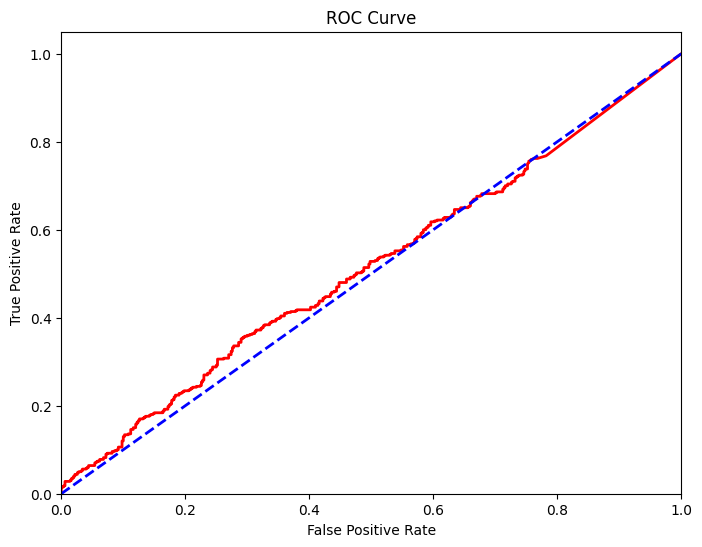

In [ ]:
# TODO: Plot results
losses, true_labels = crossentropy_loss_values(model, member_loader, nonmember_loader, device)

# print(type(losses))
# print(type(true_labels))


# ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(true_labels, losses, pos_label=0)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [ ]:
# TODO: Comment on Observations
#The AUC value of 0.51 suggest that the attack is extremely weak.
#The model's loss values don't effectively distinguish between members and non-members
#thus the attack is unable to accomplsih its objective. This is contrary to the LIRA paper
#which had metrics to show that the attack was strong.

# Problem 2

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate

In [ ]:
# Load the dataset
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/Email_data.csv')  # Replace with the actual path
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,file,message
0,427616,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...
1,108773,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...
2,355471,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...
3,457837,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...
4,124910,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Email Text
data['message'].head(2)

,message
0,Message-ID: <21013688.1075844564560.JavaMail.e...
1,Message-ID: <22688499.1075854130303.JavaMail.e...


In [ ]:
# Example Email
print(data['message'].iloc[0][:550])

Message-ID: <21013688.1075844564560.JavaMail.evans@thyme>
Date: Tue, 29 Aug 2000 01:26:00 -0700 (PDT)
From: sara.shackleton@enron.com
To: william.bradford@enron.com
Subject: Re: Credit Derivatives
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Sara Shackleton
X-To: William S Bradford
X-cc: 
X-bcc: 
X-Folder: \Sara_Shackleton_Dec2000_June2001_1\Notes Folders\Sent
X-Origin: SHACKLETON-S
X-FileName: sshackle.nsf

Bill:  Thanks for the info.   I also spoke with Jeff about how 
EnronCredit.com Lt


In [ ]:
# TODO: Load and Fine tune mdoel

# Model
pythia_model = AutoModelForCausalLM.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Split the data into train (2/3) and test (1/3) sets


train_data, test_data = train_test_split(data,test_size=0.33,random_state=42)


# Tokenize the emails
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

# def tokenize_function(examples):
#     return tokenizer(
#         examples["message"],
#         truncation=True,
#         padding=True,
#         max_length=512,
#     )

# # Convert to Hugging Face datasets
# train_dataset = Dataset.from_pandas(train_data)
# test_dataset = Dataset.from_pandas(test_data)

# # Tokenize the datasets
# train_tokenized = train_dataset.map(tokenize_function, batched=True)
# test_tokenized = test_dataset.map(tokenize_function, batched=True)

# # Training arguments
# training_args = TrainingArguments(
#     output_dir="./pythia-fine-tuned",
#     num_train_epochs=10,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     warmup_steps=500,
#     weight_decay=0.01,
# )

# # Initialize the Trainer
# trainer = Trainer(
#     model=pythia_model,
#     args=training_args,
#     train_dataset=train_tokenized,
#     eval_dataset=test_tokenized,
# )

# # Print dataset sizes
# print(f"Training set size: {len(train_data)}")
# print(f"Test set size: {len(test_data)}")

# # Print an example from the training data
# print("\nExample email from training set:")
# print(train_data['message'].iloc[0][:550])

#Save the fine-tuned model
# pythia_model.save_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")
# tokenizer.save_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")

591     Message-ID: <24048650.1075853975914.JavaMail.e...
664     Message-ID: <8189273.1075840887983.JavaMail.ev...
195     Message-ID: <9300560.1075851573421.JavaMail.ev...
1240    Message-ID: <7654943.1075842838727.JavaMail.ev...
1048    Message-ID: <30379452.1075854430023.JavaMail.e...
                              ...                        
1130    Message-ID: <21859410.1075852282055.JavaMail.e...
1294    Message-ID: <11613616.1075849659137.JavaMail.e...
860     Message-ID: <19463108.1075852096010.JavaMail.e...
1459    Message-ID: <9982296.1075840531689.JavaMail.ev...
1126    Message-ID: <2462383.1075856344807.JavaMail.ev...
Name: message, Length: 1005, dtype: object


In [ ]:
fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")

#Report the perplexity of the original and fine-tuned model.

perplexity_metric = evaluate.load("perplexity")

pythia_model.eval()
# Calculate perplexity
ft_results = perplexity_metric.compute(
    model_id='EleutherAI/pythia-70m-deduped',
    predictions=test_data['message'].tolist(),
    batch_size=8,
    max_length=512,
)

print(f"Perplexity of the fine-tuned: {ft_results['mean_perplexity']}")

fine_tuned_model.eval()
results = perplexity_metric.compute(
    model_id='/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia',
    predictions=test_data['message'].tolist(),
    batch_size=8,
    max_length=512,
)
print(f"Perplexity of the original: {results['mean_perplexity']}")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Perplexity of the fine-tuned: 29.584752663699064


  0%|          | 0/62 [00:00<?, ?it/s]

Perplexity of the original: 39.115910374034534


In [ ]:
original_perplexity = results['mean_perplexity']
print("The original perplexity", original_perplexity)

finetuned_perplexity = ft_results['mean_perplexity']
print("The fine tuned perplexity", finetuned_perplexity)

The original perplexity 39.115910374034534
The fine tuned perplexity 29.584752663699064


In [ ]:

train_random_samples = train_data.sample(n=100, random_state=42)
test_random_samples = test_data.sample(n=100, random_state=42)


train_messages = list(train_random_samples['message'])
test_messages = list(test_random_samples['message'])


**The perplexity-based loss attack**

In [ ]:
# Perform Two attacks on these samples on the fine-tuning model
def get_model_and_tokenizer(model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer, device

def calculate_perplexity(text, model, tokenizer, device):
    """Calculate perplexity score for a given text sample."""
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    return torch.exp(loss).item()
def find_optimal_threshold(member_samples: List[str], non_member_samples: List[str], model, tokenizer, device) -> float:

    # Calculate perplexities for both sets
    member_perplexities = [calculate_perplexity(text, model, tokenizer, device)
                          for text in member_samples]
    non_member_perplexities = [calculate_perplexity(text, model, tokenizer, device)
                              for text in non_member_samples]

    # Try different thresholds
    all_perplexities = sorted(member_perplexities + non_member_perplexities)
    best_threshold = None
    best_accuracy = 0

    for threshold in all_perplexities:
        member_correct = sum(1 for p in member_perplexities if p < threshold)
        non_member_correct = sum(1 for p in non_member_perplexities if p >= threshold)

        accuracy = (member_correct + non_member_correct) / (
            len(member_perplexities) + len(non_member_perplexities))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold

def predict_membership(text: str, threshold: float, model, tokenizer, device) -> Tuple[bool, float]:
    """Predict whether a text sample is a member of the training set."""
    perplexity = calculate_perplexity(text, model, tokenizer, device)
    is_member = perplexity < threshold

    # Calculate confidence based on distance from threshold
    confidence = abs(perplexity - threshold) / threshold
    confidence = min(confidence, 1.0)

    return is_member, confidence, perplexity

def evaluate_attack(test_members: List[str],
                   test_non_members: List[str],
                   threshold: float,
                   model,
                   tokenizer,
                   device) -> dict:
    """Evaluate attack performance on test sets."""
    results = {'true_positives': 0, 'false_positives': 0,
              'true_negatives': 0, 'false_negatives': 0}

    # Test member samples
    for text in test_members:
        is_member, _, _ = predict_membership(text, threshold, model, tokenizer, device)
        if is_member:
            results['true_positives'] += 1
        else:
            results['false_negatives'] += 1

    # Test non-member samples
    for text in test_non_members:
        is_member, _, _ = predict_membership(text, threshold, model, tokenizer, device)
        if is_member:
            results['false_positives'] += 1
        else:
            results['true_negatives'] += 1

    # Calculate metrics
    total = sum(results.values())
    accuracy = (results['true_positives'] + results['true_negatives']) / total

    precision = (results['true_positives'] /
                (results['true_positives'] + results['false_positives'])
                if (results['true_positives'] + results['false_positives']) > 0 else 0)

    recall = (results['true_positives'] /
             (results['true_positives'] + results['false_negatives'])
             if (results['true_positives'] + results['false_negatives']) > 0 else 0)

    f1 = (2 * (precision * recall) / (precision + recall)
          if (precision + recall) > 0 else 0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'raw_results': results
    }

In [ ]:
pretrained_path = "EleutherAI/pythia-70m-deduped"
finetuned_path = "/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia"

finetuned_model, tokenizer, device = get_model_and_tokenizer(finetuned_path)

test_members = train_messages
test_non_members = test_messages

#Threshold
threshold = find_optimal_threshold(test_members,test_non_members,finetuned_model,tokenizer, device)
print(f"T: {threshold}")

#ASR
metrics = evaluate_attack(test_members, test_non_members, threshold,finetuned_model, tokenizer, device)
print(f"ASR: {metrics}")

T: 53.587947845458984
ASR: {'accuracy': 0.525, 'precision': 0.5144508670520231, 'recall': 0.89, 'f1_score': 0.6520146520146519, 'raw_results': {'true_positives': 89, 'false_positives': 84, 'true_negatives': 16, 'false_negatives': 11}}


**Normalized perplexity attack**

In [ ]:
def get_model_and_tokenizer(pretrained_name, finetuned_path):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pretrained_model = AutoModelForCausalLM.from_pretrained(pretrained_path).to(device)
    finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_path).to(device)
    finetuned_tokenizer = AutoTokenizer.from_pretrained(pretrained_path)

    return pretrained_model, finetuned_model, tokenizer, device

def calculate_perplexity(text, model, tokenizer, device):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    return torch.exp(loss).item()

def calculate_normalized_perplexity(text,pretrained_model,finetuned_model,tokenizer,device):
    pretrained_perplexity = calculate_perplexity(text, pretrained_model, tokenizer, device)
    finetuned_perplexity = calculate_perplexity(text, finetuned_model, tokenizer, device)

    # Avoid division by zero
    if pretrained_perplexity == 0:
        pretrained_perplexity = 1e-10

    normalized_perplexity = finetuned_perplexity / pretrained_perplexity
    return normalized_perplexity

def find_optimal_threshold(member_samples: List[str],non_member_samples: List[str],pretrained_model,finetuned_model,tokenizer,device):
    # Calculate normalized perplexities
    member_perplexities = [
        calculate_normalized_perplexity(
            text, pretrained_model, finetuned_model, tokenizer, device
        ) for text in member_samples
    ]

    non_member_perplexities = [
        calculate_normalized_perplexity(
            text, pretrained_model, finetuned_model, tokenizer, device
        ) for text in non_member_samples
    ]

    # Find optimal threshold
    all_perplexities = sorted(member_perplexities + non_member_perplexities)
    best_threshold = None
    best_accuracy = 0

    for threshold in all_perplexities:
        member_correct = sum(1 for p in member_perplexities if p < threshold)
        non_member_correct = sum(1 for p in non_member_perplexities if p >= threshold)

        accuracy = (member_correct + non_member_correct) / (
            len(member_perplexities) + len(non_member_perplexities))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold

def predict_membership(text,threshold,pretrained_model,finetuned_model,tokenizer,device):
    norm_perplexity = calculate_normalized_perplexity(
        text, pretrained_model, finetuned_model, tokenizer, device
    )

    is_member = norm_perplexity < threshold

    # Calculate confidence based on distance from threshold
    confidence = abs(norm_perplexity - threshold) / threshold
    confidence = min(confidence, 1.0)

    return is_member, confidence, norm_perplexity

def evaluate_attack(test_members: List[str],
                   test_non_members: List[str],
                   threshold: float,
                   pretrained_model,
                   finetuned_model,
                   tokenizer,
                   device) -> dict:

    results = {
        'true_positives': 0,
        'false_positives': 0,
        'true_negatives': 0,
        'false_negatives': 0,
        'member_perplexities': [],
        'non_member_perplexities': []
    }

    # Test member samples
    for text in test_members:
        is_member, _, norm_perplexity = predict_membership(
            text, threshold, pretrained_model, finetuned_model, tokenizer, device
        )
        results['member_perplexities'].append(norm_perplexity)
        if is_member:
            results['true_positives'] += 1
        else:
            results['false_negatives'] += 1

    # Test non-member samples
    for text in test_non_members:
        is_member, _, norm_perplexity = predict_membership(
            text, threshold, pretrained_model, finetuned_model, tokenizer, device
        )
        results['non_member_perplexities'].append(norm_perplexity)
        if is_member:
            results['false_positives'] += 1
        else:
            results['true_negatives'] += 1

    # Calculate metrics
    total = len(test_members) + len(test_non_members)
    accuracy = (results['true_positives'] + results['true_negatives']) / total

    precision = (results['true_positives'] /
                (results['true_positives'] + results['false_positives'])
                if (results['true_positives'] + results['false_positives']) > 0 else 0)

    recall = (results['true_positives'] /
             (results['true_positives'] + results['false_negatives'])
             if (results['true_positives'] + results['false_negatives']) > 0 else 0)

    f1 = (2 * (precision * recall) / (precision + recall)
          if (precision + recall) > 0 else 0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'raw_results': results
    }

In [ ]:
# Load models and tokenizer
pretrained_name = "EleutherAI/pythia-70m-deduped"  # base model
finetuned_name = "/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia"
pretrained_model, finetuned_model, tokenizer, device = load_models_and_tokenizer(
    pretrained_name, finetuned_name
)

#Emails Inputs
test_members = train_messages
test_non_members = test_messages


# Threshold
threshold = find_optimal_threshold(test_members, test_non_members,finetuned_model,tokenizer, device)
print(f"T: {threshold}")


# Evaluate attack performance
metrics = evaluate_attack(test_members, test_non_members, threshold,finetuned_model,tokenizer, device)
print(f"ASR: {metrics}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


T: 53.587947845458984
ASR: {'accuracy': 0.525, 'precision': 0.5144508670520231, 'recall': 0.89, 'f1_score': 0.6520146520146519, 'raw_results': {'true_positives': 89, 'false_positives': 84, 'true_negatives': 16, 'false_negatives': 11}}


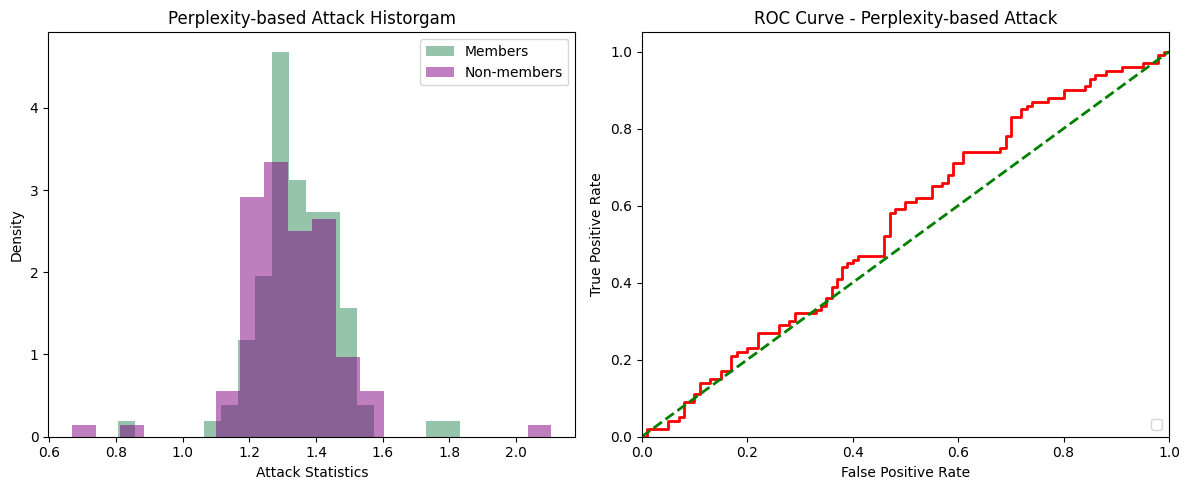


Metrics Summary for Perplexity-based Attack:
AUC Score: 0.550
TPR at 0.1% FPR: 0.000
TPR at 1% FPR: 0.000
TPR at 10% FPR: 0.090


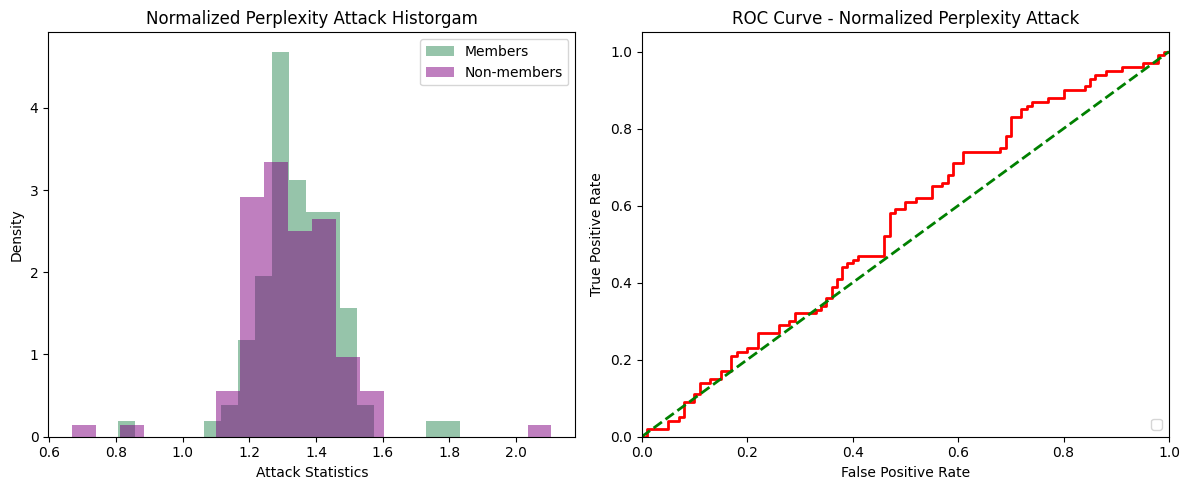


Metrics Summary for Normalized Perplexity Attack:
AUC Score: 0.550
TPR at 0.1% FPR: 0.000
TPR at 1% FPR: 0.000
TPR at 10% FPR: 0.090


In [ ]:
# TODO: Plot results
def plot_attack_analysis(member_scores, nonmember_scores, attack_name=""):

    #labels
    y_true = np.concatenate([np.ones(len(member_scores)), np.zeros(len(nonmember_scores))])
    y_scores = np.concatenate([member_scores, nonmember_scores])

    #histograms
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(member_scores, bins=20, alpha=0.5, label='Members', density=True, color='seagreen')
    plt.hist(nonmember_scores, bins=20, alpha=0.5, label='Non-members', density=True, color='purple')
    plt.xlabel('Attack Statistics')
    plt.ylabel('Density')
    plt.title(f'{attack_name} Historgam')
    plt.legend()

    # ROC curve and metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Find TPR at specific FPR thresholds
    def get_tpr_at_fpr(target_fpr):
        idx = np.searchsorted(fpr, target_fpr)
        return tpr[idx]

    tpr_01_fpr = get_tpr_at_fpr(0.001)
    tpr_1_fpr = get_tpr_at_fpr(0.01)
    tpr_10_fpr = get_tpr_at_fpr(0.1)

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {attack_name}')
    plt.legend(loc="bottom right")

    plt.tight_layout()
    plt.show()

    #Print
    print(f"\nMetrics Summary for {attack_name}:")
    print(f"AUC Score: {roc_auc:.3f}")
    print(f"TPR at 0.1% FPR: {tpr_01_fpr:.3f}")
    print(f"TPR at 1% FPR: {tpr_1_fpr:.3f}")
    print(f"TPR at 10% FPR: {tpr_10_fpr:.3f}")

# Plots

member_perplexity_list = []
for each in train_messages:
    result = calculate_normalized_perplexity(each, pretrained_model, finetuned_model, tokenizer, device)
    member_perplexity_list.append(result)
member_perplexities = np.array(member_perplexity_list)


non_member_perplexity_list = []
for each in test_messages:
    result = calculate_normalized_perplexity(each, pretrained_model, finetuned_model, tokenizer, device)
    non_member_perplexity_list.append(result)
non_member_perplexities = np.array(non_member_perplexity_list)


plot_attack_analysis(member_perplexities, non_member_perplexities, "Perplexity-based Attack")


plot_attack_analysis(member_perplexities, non_member_perplexities, "Normalized Perplexity Attack")

In [ ]:
# TODO: Comment on Observations

# The normalized based attack is a strong attack that reduces
# the impact of corpus token variations for our model. However, the
#results show that there was no difference in the strenth of the
#attack between the perplexity and the normalized attack.

# Problem 3

In [172]:
import random

fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")

In [175]:

fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")

vocab_size = fine_tuned_tokenizer.vocab_size
random_token = random.randint(0, vocab_size-1)


input_ids = torch.tensor([[random_token]]).to(fine_tuned_model.device)

# Generate text
with torch.no_grad():
    outputs = fine_tuned_model.generate(
        input_ids,
        max_length=1000,
        do_sample=True,
        temperature=1.0,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

# Generated

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


iva.

The first of the three children of the school were the first children of the school. The second child of the school was the second child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the school. The third child of the school was the third child of the schoo

In-set email 1 BLEU score: 0.0009
In-set email 2 BLEU score: 0.0084
In-set email 3 BLEU score: 0.0011
In-set email 4 BLEU score: 0.0019
In-set email 5 BLEU score: 0.0004
In-set email 6 BLEU score: 0.0023
In-set email 7 BLEU score: 0.0007
In-set email 8 BLEU score: 0.0006
In-set email 9 BLEU score: 0.0005
In-set email 10 BLEU score: 0.0007
Out-of-set email 1 BLEU score: 0.0017
Out-of-set email 2 BLEU score: 0.0014
Out-of-set email 3 BLEU score: 0.0043
Out-of-set email 4 BLEU score: 0.0009
Out-of-set email 5 BLEU score: 0.0004
Out-of-set email 6 BLEU score: 0.0022
Out-of-set email 7 BLEU score: 0.0015
Out-of-set email 8 BLEU score: 0.0006
Out-of-set email 9 BLEU score: 0.0000
Out-of-set email 10 BLEU score: 0.0004


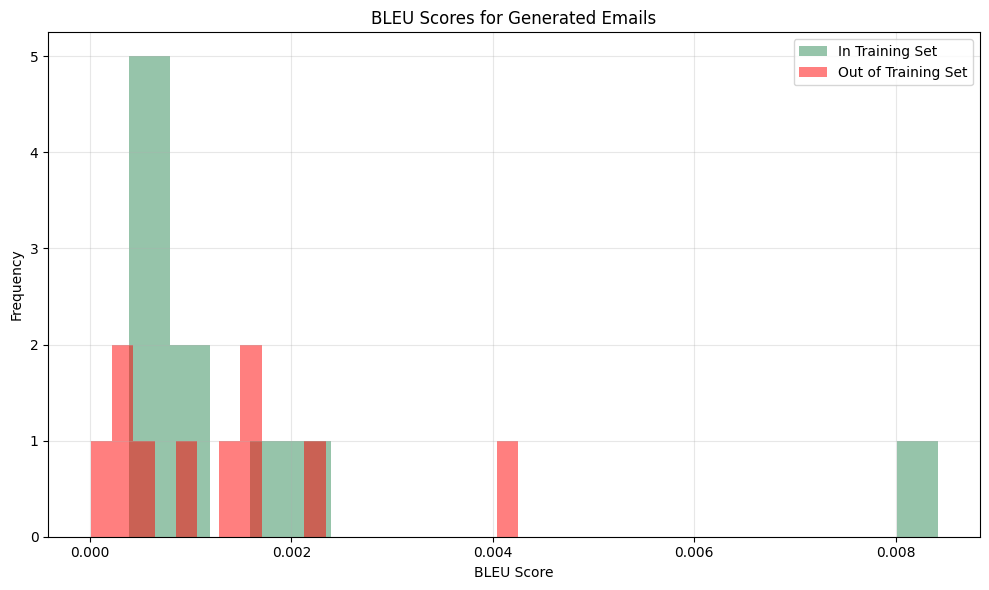

In [179]:
test_members = train_messages
test_non_members = test_messages

def generate_email(model, tokenizer, max_length=1000):

    vocab_size = tokenizer.vocab_size
    random_token = random.randint(0, vocab_size-1)

    # Generate text
    input_ids = torch.tensor([[random_token]]).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=1.0,
            pad_token_id=tokenizer.pad_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def bleu_score(reference, candidate):
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    references = [reference_tokens]
    smoothing = SmoothingFunction().method1

def plot_bleu_scores(model, tokenizer, in_set_emails, out_set_emails, num_samples=10):

    in_set_emails = test_members[:num_samples]
    out_set_emails = test_non_members[:num_samples]

    bleu_scores_in = []
    bleu_scores_out = []

    for i, ref_email in enumerate(in_set_emails):
        generated = generate_email(model, tokenizer)
        bleu = bleu_score(ref_email, generated)
        bleu_scores_in.append(bleu)
        print(f"In-set email {i+1} BLEU score: {bleu:.4f}")

    for i, ref_email in enumerate(out_set_emails):
        generated = generate_email(model, tokenizer)
        bleu = bleu_score(ref_email, generated)
        bleu_scores_out.append(bleu)
        print(f"Out-of-set email {i+1} BLEU score: {bleu:.4f}")

    # Create histogram
    plt.figure(figsize=(10, 6))

    # Histograms
    plt.hist(bleu_scores_in, alpha=0.5, label='In Training Set', color='seagreen', bins=20)
    plt.hist(bleu_scores_out, alpha=0.5, label='Out of Training Set', color='red', bins=20)

    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('BLEU Scores for Generated Emails')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return bleu_scores_in, bleu_scores_out

# model and tokenizer
fine_tuned_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/CS6983_GenAI_Folder/Homework_3/fine_tuned_pythia")

in_set_emails = test_members
out_set_emails = test_non_members

bleu_scores_in, bleu_scores_out = plot_bleu_scores(
    fine_tuned_model,
    tokenizer,
    in_set_emails,
    out_set_emails
)

Note: Generated using Claude Framework as a guide

Citation: https://thepythoncode.com/article/bleu-score-in-python

In [ ]:
# Discuss your observations:

# The data extraction attack on emails IN the fine-tuning is similar to
# the attack on emails OUT of the fine-tuning. however, the data extraction attack on emails in the
# dataset had a higher max BLEU score compared to those outside of the Trianing dataset.
